## Medical Insurance Payout Prediction

Dataset Source: https://www.kaggle.com/datasets/harshsingh2209/medical-insurance-payout

#### Import Necessary Libraries

In [1]:
import sys, math
from statistics import mean

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import SGDRegressor, ElasticNet, HuberRegressor
from sklearn.linear_model import RANSACRegressor, TheilSenRegressor
from sklearn.svm import SVR

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.ensemble import StackingRegressor, VotingRegressor, BaggingRegressor

import xgboost as xgb
from xgboost import XGBRegressor

#### Show Library Versions

In [2]:
n = 18

print(f"Language/Library".rjust(n-2), '|', 'Version')
print('-' * (n-2), '|', '--------')
print("Python :".rjust(n), sys.version[0:6])
print("NumPy :".rjust(n), np.__version__)
print("Pandas :".rjust(n), pd.__version__)
print("Sklearn :".rjust(n), sklearn.__version__)
print('XGBoost :'.rjust(n), xgb.__version__)
print("Seaborn :".rjust(n), sns.__version__)

Language/Library | Version
---------------- | --------
          Python : 3.9.12
           NumPy : 1.24.3
          Pandas : 2.0.1
         Sklearn : 1.2.2
         XGBoost : 1.7.5
         Seaborn : 0.12.2


### Initial Data Preprocessing

#### Ingest Dataset

In [3]:
col_names = ["age",
             "sex",
             "bmi",
             "children",
             "smoker",
             "region",
             "label"
             ]

dtypes = {"age": np.uint8,
          "sex": str,
          "bmi": np.float32,
          "children": np.uint8,
          "smoker": str,
          "region": str,
          "label": np.float32
          }

data = pd.read_csv("expenses.csv",
                   names=col_names, 
                   dtype=dtypes,
                   engine='c',
                   header=0)

data.head()

,age,sex,bmi,children,smoker,region,label
0,19,female,27.900000,0,yes,southwest,16884.923828
1,18,male,33.770000,1,no,southeast,1725.552246
2,28,male,33.000000,3,no,southeast,4449.461914
3,33,male,22.705000,0,no,northwest,21984.470703
4,32,male,28.879999,0,no,northwest,3866.855225


#### More Dataset Information

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   uint8  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float32
 3   children  1338 non-null   uint8  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   label     1338 non-null   float32
dtypes: float32(2), object(3), uint8(2)
memory usage: 44.6+ KB


### Visualizations

#### Create Function to Visualize Features (Histograms)

In [5]:
def histogram_visual(feature_to_visualize: pd.Series,
                     num_of_bins: int,
                     plot_title: str,
                     x_label: str,
                     x_start: float = -1.0,
                     y_label: str = "# of Samples",
                     ):
    """
    This function returns a histogram for a feature.
    
    Inputs: 
    - feature_to_visualize: Feature to plot in the form 
    of pandas Series.
    - plot_title: The title of the plot/visual.
    - x_label: The string label value for the x label.
    - x_start: To force the x-axis of the visual to start at 
    a specified value instead of the automatically generated 
    value, assign the float value here. Otherwise, the 
    autogenerated start value will be used.
    - y_label: The string label value for the y label.
    
    Output:
    - A histogram.
    """
    
    assert type(feature_to_visualize) == pd.Series, \
        "Make sure the dataset input type is a Pandas Series."
    assert type(plot_title) != 'str', \
        "The title value must be a string value."
    assert type(x_label) !=  'str', \
        "The x label value must be a string value."
    assert type(y_label) != 'str', \
        "The y label value must be a string value."
    assert type(x_start) != 'float', \
        "The x_start value must be a float value."
    
    ax = feature_to_visualize.hist(grid=False, 
                                   bins=num_of_bins, 
                                   figsize=(18, 8))
    plt.suptitle('')
    plt.title(plot_title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    
    if x_start != -1:
        plt.xlim([0, (max(feature_to_visualize) + (1/num_of_bins))])

    plt.show()

#### Dataset Visualization: Customer's Ages

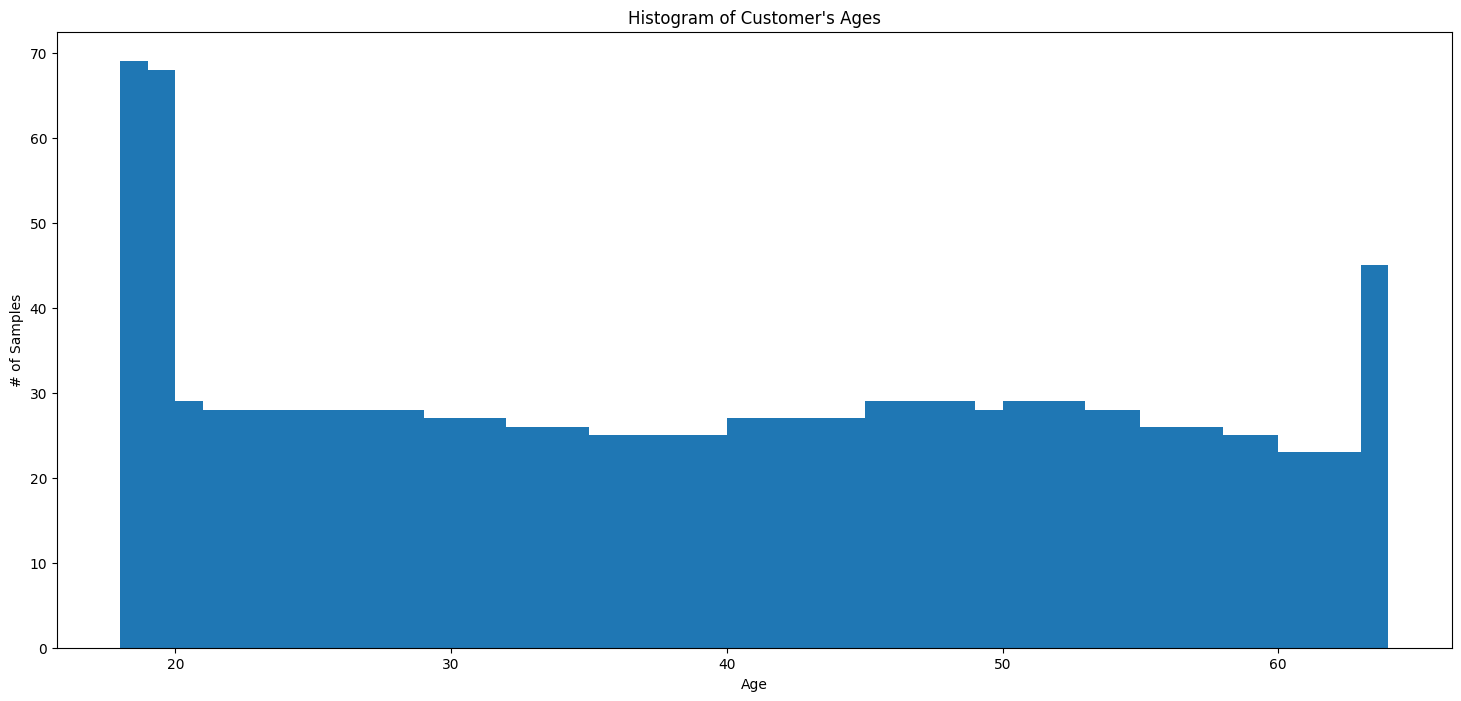

The age range is 18 to 64 years old.


In [6]:
histogram_visual(data['age'],
                 num_of_bins=46,
                 plot_title="Histogram of Customer's Ages",
                 x_label="Age")

print(f"The age range is {min(data['age'])} to" + 
      f" {max(data['age'])} years old.")

#### Dataset Visualization: Body Mass Index (BMI)

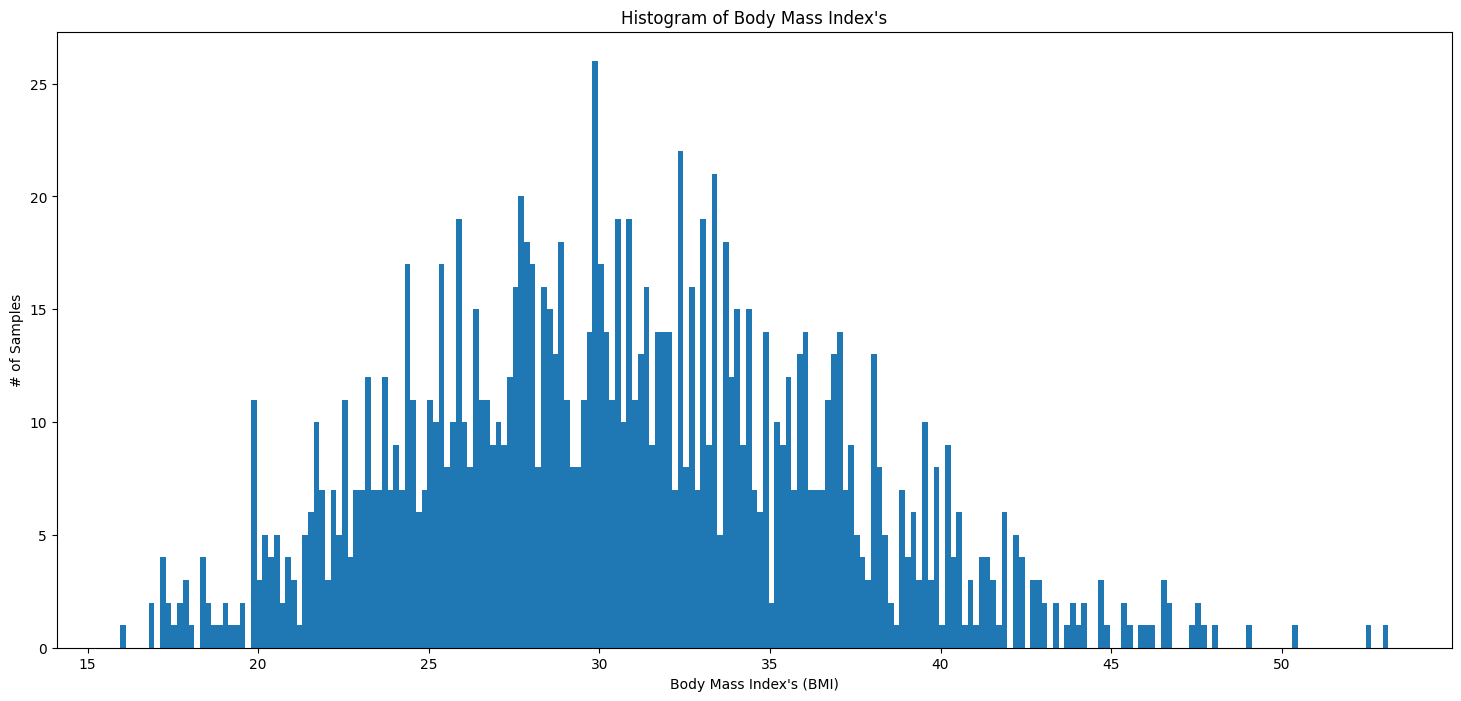

Customer's Body Mass Index's (BMIs) ranged from 15.96 to 53.13.


In [7]:
histogram_visual(data['bmi'],
                 num_of_bins=223,
                 plot_title="Histogram of Body Mass Index's",
                 x_label="Body Mass Index's (BMI)")

print(f"Customer's Body Mass Index's (BMIs) ranged" +
      f" from {round(min(data['bmi']), 2)}" + 
      f" to {round(max(data['bmi']), 2)}.")

#### Dataset Visualization: Customer's Predicted Payout Amount 

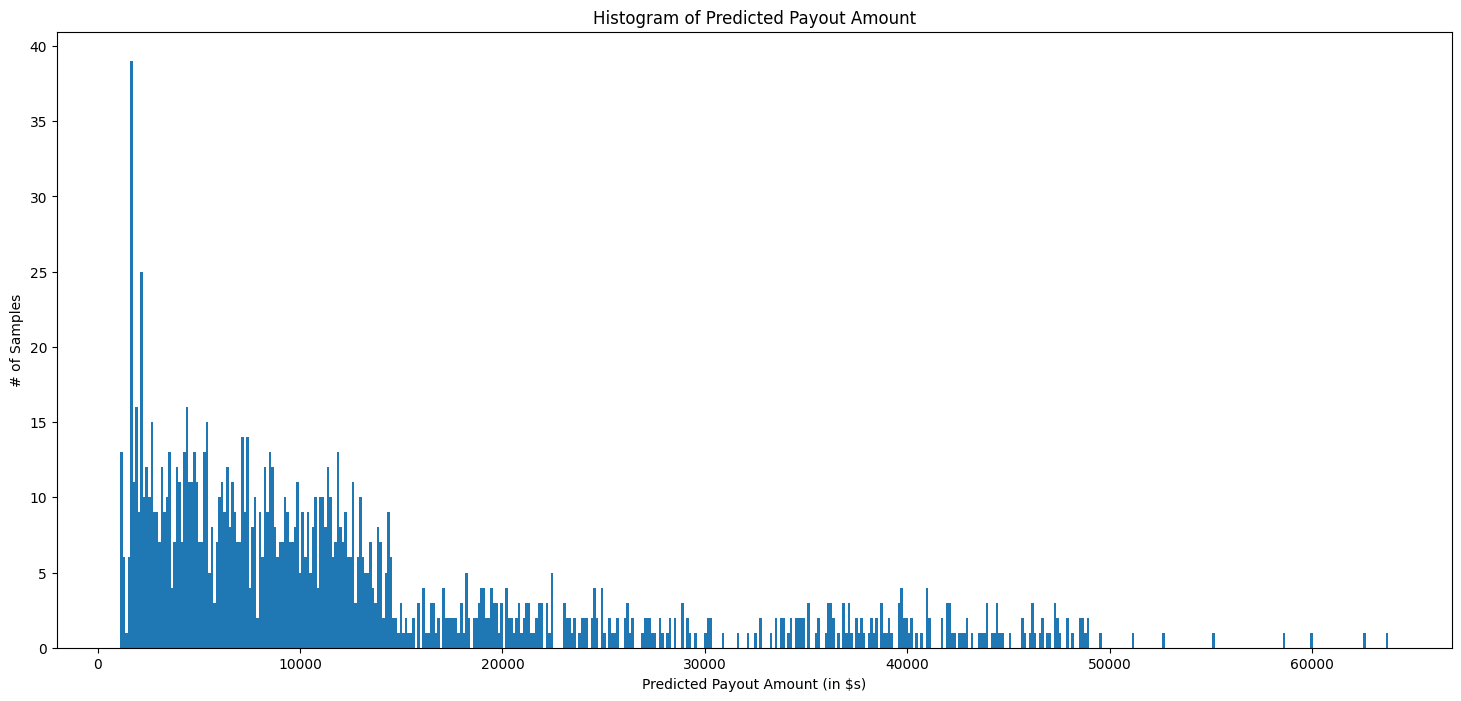

The predicted payout amount ranges from $1121.87 to $63770.43.


In [8]:
histogram_visual(data['label'],
                 num_of_bins=504,
                 plot_title="Histogram of Predicted Payout Amount",
                 x_label="Predicted Payout Amount (in $s)")

print(f"The predicted payout amount ranges from" + 
      f" ${round(min(data['label']),2)} to" + 
      f" ${round(max(data['label']),2)}.")

#### Create Function to Visualize Features (Barplot)

In [9]:
def barplot_visual(feature_to_visualize: pd.Series,
                   plot_title: str,
                   x_label: str,
                   y_label: str = "# of Samples",
                   ):
    """
    This function returns a histogram for a feature.
    
    Inputs: 
    - feature_to_visualize: Feature to plot in the form 
    of pandas Series.
    - plot_title: The title of the plot/visual.
    - x_label: The string label value for the x label.
    - y_label: The string label value for the y label.
    
    Output:
    - A Bar Plot.
    """
    
    assert type(feature_to_visualize) == pd.Series, \
        "Make sure the dataset input type is a Pandas Series."
    assert type(plot_title) != 'str', \
        "The title value must be a string value."
    assert type(x_label) !=  'str', \
        "The x label value must be a string value."
    assert type(y_label) != 'str', \
        "The y label value must be a string value."
        
    ax = feature_to_visualize.value_counts().plot.bar( 
                                                      figsize=(12,8),
                                                      rot=0, 
                                                      legend=False,
                                                      color=["lightgreen", 
                                                             "blue", 
                                                             "brown", 
                                                             "lightblue",
                                                             "tan", 
                                                             "yellow", 
                                                             "orange",
                                                             "green", 
                                                             "red",
                                                             "purple"]
                                                      )
    
    ax.bar_label(ax.containers[0])
    
    plt.suptitle('')
    plt.title(plot_title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    
    plt.show()

#### Dataset Visualization: Sex

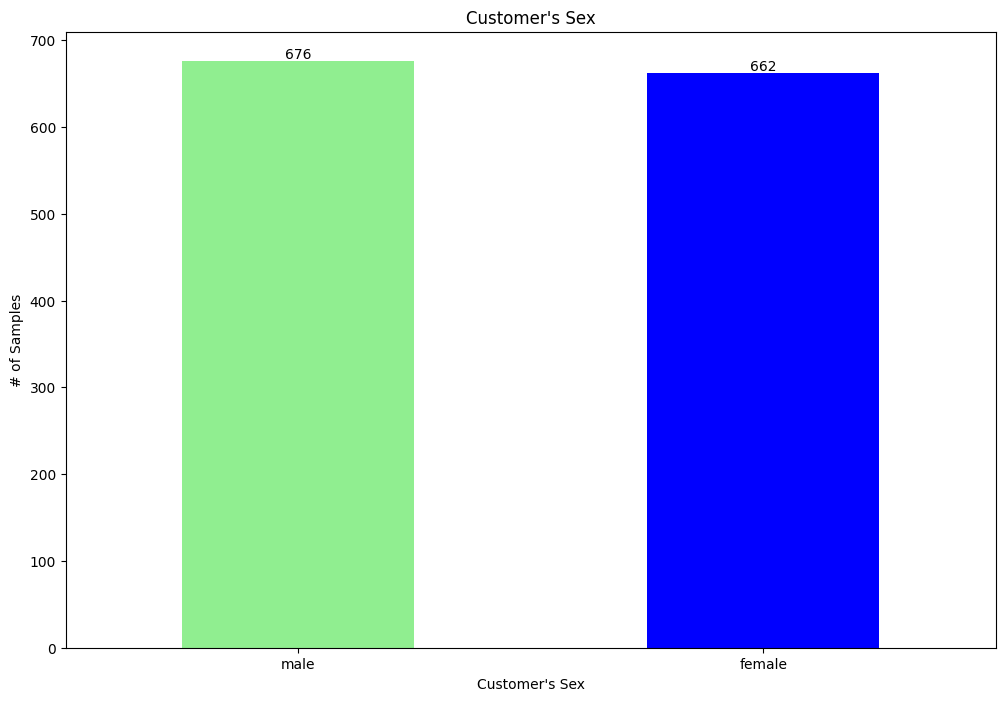

In [10]:
barplot_visual(data["sex"],
               "Customer's Sex",
               "Customer's Sex",
               "# of Samples",
               )

#### Dataset Visualization: Number of Children

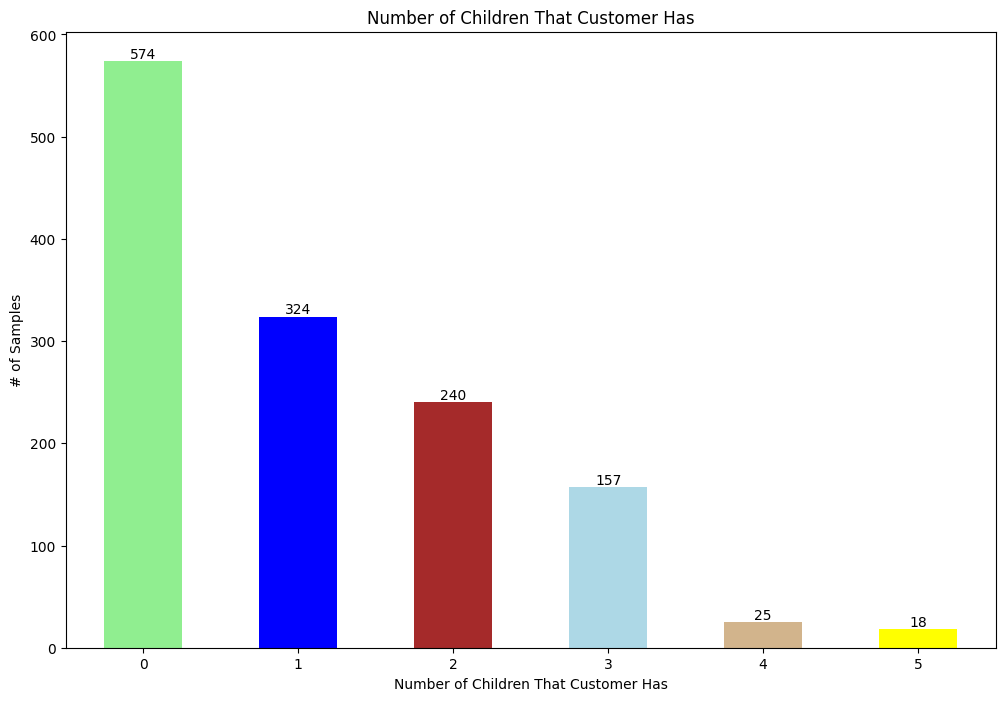

In [11]:
barplot_visual(data["children"],
               "Number of Children That Customer Has",
               "Number of Children That Customer Has",
               "# of Samples",
               )

#### Dataset Visualization: Smoker Status

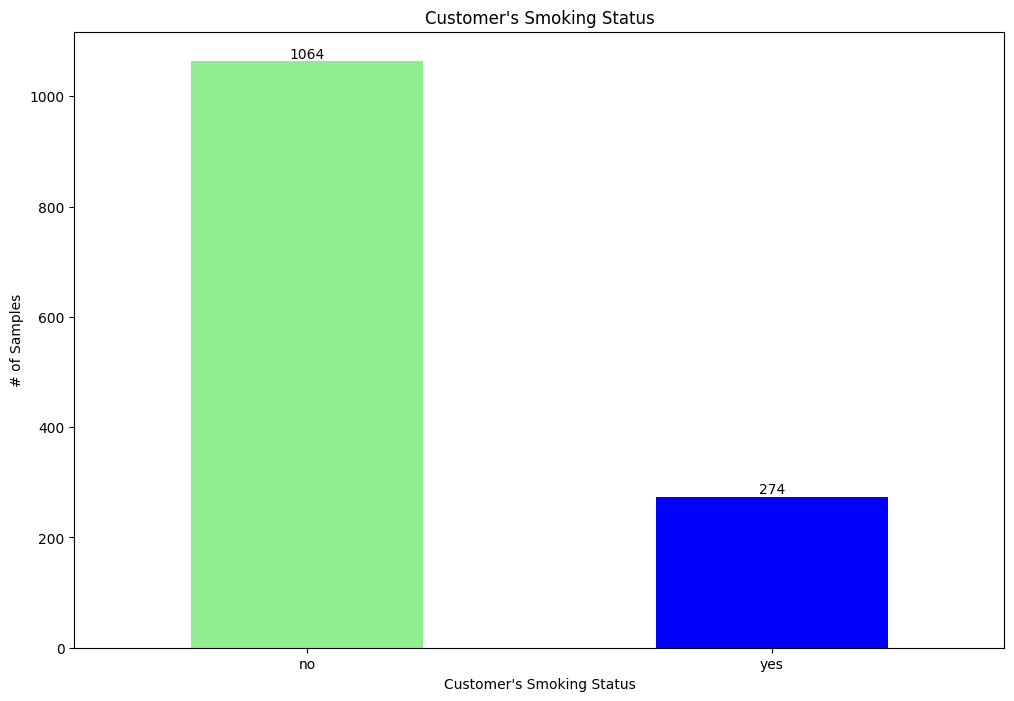

In [12]:
barplot_visual(data["smoker"],
               "Customer's Smoking Status",
               "Customer's Smoking Status",
               "# of Samples",
               )

#### Dataset Visualization: Any Chronic Diseases

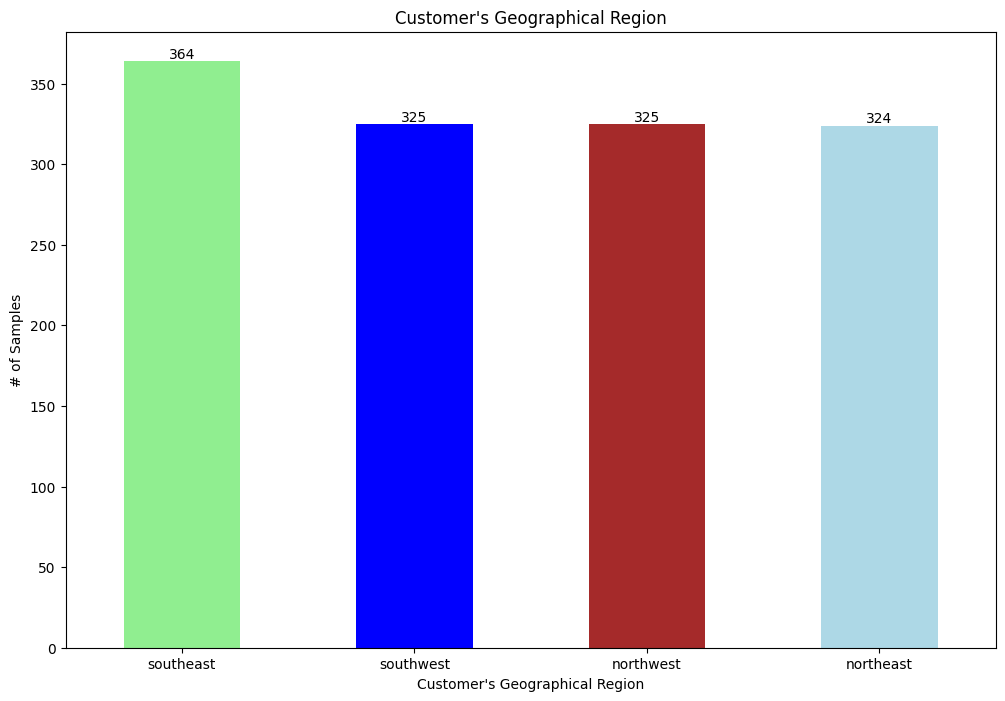

In [13]:
barplot_visual(data["region"],
               "Customer's Geographical Region",
               "Customer's Geographical Region",
               "# of Samples",
               )

### Exploratory Data Analysis & Preprocessing

#### Convert Feature Values From String to Integer

In [14]:
sex_label2id = {"female": 0, 
                "male": 1
                }

data["sex"] = data["sex"].replace(sex_label2id)

smoker_label2id = {"no": 0, 
                   "yes": 1
                   }

data["smoker"] = data["smoker"].replace(smoker_label2id)

region_label2id = {"southeast": 0,
                   "southwest": 1,
                   "northeast": 2, 
                   "northwest": 3
                   }

data["region"] = data["region"].replace(region_label2id)

#### Descriptive Statistics

In [15]:
data.describe(percentiles=[0.01, 
                           0.10, 
                           0.25, 
                           0.50, 
                           0.75, 
                           0.90, 
                           0.99
                           ], 
              include='all')

,age,sex,bmi,children,smoker,region,label
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,0.505232,30.663397,1.094918,0.204783,1.455904,13270.422852
std,14.049960,0.500160,6.098187,1.205493,0.403694,1.130888,12110.010742
min,18.000000,0.000000,15.960000,0.000000,0.000000,0.000000,1121.873901
1%,18.000000,0.000000,17.895150,0.000000,0.000000,0.000000,1252.972732
10%,19.000000,0.000000,22.990000,0.000000,0.000000,0.000000,2346.533667
25%,27.000000,0.000000,26.296251,0.000000,0.000000,0.000000,4740.287109
50%,39.000000,1.000000,30.400000,1.000000,0.000000,1.000000,9382.032715
75%,51.000000,1.000000,34.693750,2.000000,0.000000,2.000000,16639.912109
90%,59.000000,1.000000,38.619499,3.000000,1.000000,3.000000,34831.717969


### Prepare Shared Pipeline Data & Stages/Steps

#### Split Dataset into Training & Testing Datasets

In [16]:
y = data['label']
X = data.drop(columns=['label'], axis=1)

print(f"Inputs Dataset Shape: {X.shape}")
print(f"Outputs Dataset Shape: {y.shape}")

Inputs Dataset Shape: (1338, 6)
Outputs Dataset Shape: (1338,)


#### Define Column Lists for Transformers (Pipeline Stages) & Transform to Integer Values

In [17]:
numerical_features = [
    "age", 
    "bmi"
    ]

nominal_features = [x for x in data.columns if x not in numerical_features and x != 'label']

#### Remove Outliers

In [18]:
# Remove outliers using the 'IQR * 1.5' rule
def remove_outliers(df, features_to_remove):
    df = pd.DataFrame(df).copy()
    for feat in features_to_remove:
        x = df[feat]
        q1, q3 = x.quantile([0.25, 0.75])
        iqr = q3-q1
        ul = q3 + (iqr * 1.5)
        ll = q1 - (iqr * 1.5)
        neo_df = df[(df[feat] >= ll) | (df[feat] <= ul)]
    return neo_df

outlier_remover = FunctionTransformer(remove_outliers, 
                                      kw_args={
                                          'features_to_remove': numerical_features
                                          }
                                      )

#### Create Column Transformer

In [19]:
encoder_col_transformer = ColumnTransformer(
    [
        (
            "remove_outliers",
            outlier_remover,
            numerical_features
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first',
                          handle_unknown='ignore',
                          dtype=np.float64), 
            nominal_features)
    ], 
    remainder='passthrough')

#### Metrics Evaluation Method

In [20]:
regression_metric_names = ('neg_mean_absolute_error', 
                           'neg_root_mean_squared_error', 
                           )

def regression_eval(model_name: str,
                    scores: tuple(),
                    ) -> None:
    '''
    Calculate & display metrics for a regression analysis.
    '''
    
    metrics_titles = ["Mean Absolute Error", 
                      "Root Mean Squared Error", 
                      ]
        

    print("+------------------------------------------------+")
    print("|  " + ("Training " + model_name).center(44) + "  |")
    print("+------------------------------------------------+")
    print("|  %s  |  %s   | " % ("Metric".rjust(29), "Value".ljust(9)))
    print("+------------------------------------------------+")
    for x in range(len(regression_metric_names)):
        
        name = "train_" + regression_metric_names[x]
        
        score = mean(scores[name])
        
        if score < 0:
            score = score * -1
        
        print("| %s  |  %s   |" % (("Train " + metrics_titles[x]).rjust(30), str(round(score, 3)).ljust(9)))
        print("+------------------------------------------------+")
    
    print()
    
    print("+------------------------------------------------+")
    print("|  " + ("Testing " + model_name).center(44) + "  |")
    print("+------------------------------------------------+")
    print("|  %s  |  %s   | " % ("Metric".rjust(29), "Value".ljust(9)))
    print("+------------------------------------------------+")
    for x in range(len(regression_metric_names)):
        name = "test_" + regression_metric_names[x]
        score = mean(scores[name])
        
        if score < 0:
            score = score * -1
        
        print("| %s  |  %s   |" % (("Test " + metrics_titles[x]).rjust(30), str(round(score, 3)).ljust(9)))
        print("+------------------------------------------------+")

### SVM Regression (SVR)

#### Define Pipeline

In [21]:
def svm_regression():
    """
    This function creates the SVM Regression.
    """
    svmr_pipe = Pipeline(
        [
            (
                'encoder_column_transformer', 
                encoder_col_transformer),
            (
                "scaler",
                StandardScaler()),
            (
                'svm_reg', 
                SVR(kernel='poly')
             ),
        ]
        )
    
    return svmr_pipe

#### Define Model

In [22]:
svmr = svm_regression()

svmr.named_steps

{'encoder_column_transformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('remove_outliers',
                                  FunctionTransformer(func=<function remove_outliers at 0x7f98c81d9ee0>,
                                                      kw_args={'features_to_remove': ['age',
                                                                                      'bmi']}),
                                  ['age', 'bmi']),
                                 ('ohe',
                                  OneHotEncoder(drop='first',
                                                handle_unknown='ignore'),
                                  ['sex', 'children', 'smoker', 'region'])]),
 'scaler': StandardScaler(),
 'svm_reg': SVR(kernel='poly')}

#### Fit Algorithm to Dataset

In [23]:
scores = cross_validate(svmr, 
                        X, 
                        y, 
                        cv=8,
                        scoring=regression_metric_names,
                        return_train_score=True)

#### Metrics Evaluation

In [24]:
regression_eval("SVM Regression", 
                scores)

+------------------------------------------------+
|            Training SVM Regression             |
+------------------------------------------------+
|                         Metric  |  Value       | 
+------------------------------------------------+
|      Train Mean Absolute Error  |  8329.433    |
+------------------------------------------------+
|  Train Root Mean Squared Error  |  12688.099   |
+------------------------------------------------+

+------------------------------------------------+
|             Testing SVM Regression             |
+------------------------------------------------+
|                         Metric  |  Value       | 
+------------------------------------------------+
|       Test Mean Absolute Error  |  8335.881    |
+------------------------------------------------+
|   Test Root Mean Squared Error  |  12653.158   |
+------------------------------------------------+


### ElasticNet Regression

#### Define Pipeline

In [25]:
def elastic_net_regression():
    """
    This function creates the ElasticNet Regression.
    """
    en_reg_pipe = Pipeline(
        [
            (
                'encoder_column_transformer', 
                encoder_col_transformer
            ),
            (
                'scaler', 
                StandardScaler(),
            ),
            (
                'elastic_net_reg', 
                ElasticNet(selection='random',
                           random_state=42, 
                           max_iter=2000, 
                           alpha=0.0001
                           )
             ),
        ]
        )
    
    return en_reg_pipe

#### Define Model

In [26]:
enr = elastic_net_regression()

enr.named_steps

{'encoder_column_transformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('remove_outliers',
                                  FunctionTransformer(func=<function remove_outliers at 0x7f98c81d9ee0>,
                                                      kw_args={'features_to_remove': ['age',
                                                                                      'bmi']}),
                                  ['age', 'bmi']),
                                 ('ohe',
                                  OneHotEncoder(drop='first',
                                                handle_unknown='ignore'),
                                  ['sex', 'children', 'smoker', 'region'])]),
 'scaler': StandardScaler(),
 'elastic_net_reg': ElasticNet(alpha=0.0001, max_iter=2000, random_state=42, selection='random')}

#### Fit Algorithm to Dataset

In [27]:
scores = cross_validate(enr, 
                        X, 
                        y, 
                        cv=8,
                        scoring=regression_metric_names,
                        return_train_score=True)

#### Metrics Evaluation

In [28]:
regression_eval("ElasticNet Regression", 
                scores)

+------------------------------------------------+
|         Training ElasticNet Regression         |
+------------------------------------------------+
|                         Metric  |  Value       | 
+------------------------------------------------+
|      Train Mean Absolute Error  |  4173.842    |
+------------------------------------------------+
|  Train Root Mean Squared Error  |  6024.837    |
+------------------------------------------------+

+------------------------------------------------+
|         Testing ElasticNet Regression          |
+------------------------------------------------+
|                         Metric  |  Value       | 
+------------------------------------------------+
|       Test Mean Absolute Error  |  4216.534    |
+------------------------------------------------+
|   Test Root Mean Squared Error  |  6080.401    |
+------------------------------------------------+


### Kernel Ridge Regression

#### Define Pipeline

In [29]:
def kernel_ridge_regression():
    """
    This function creates the Kernel Ridge Regression.
    """
    kernel_ridge_pipe = Pipeline(
        [
            (
                'encoder_column_transformer', 
                encoder_col_transformer
            ),
            (
                "scaler",
                StandardScaler()
            ),
            (
                'kernel_ridge_reg', 
                KernelRidge(kernel='polynomial', 
                            degree=3, 
                            gamma=0.01, 
                            alpha=0.80)
             ),
        ]
    )
    
    return kernel_ridge_pipe

#### Define Model

In [30]:
kr_reg = kernel_ridge_regression()

kr_reg.named_steps

{'encoder_column_transformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('remove_outliers',
                                  FunctionTransformer(func=<function remove_outliers at 0x7f98c81d9ee0>,
                                                      kw_args={'features_to_remove': ['age',
                                                                                      'bmi']}),
                                  ['age', 'bmi']),
                                 ('ohe',
                                  OneHotEncoder(drop='first',
                                                handle_unknown='ignore'),
                                  ['sex', 'children', 'smoker', 'region'])]),
 'scaler': StandardScaler(),
 'kernel_ridge_reg': KernelRidge(alpha=0.8, gamma=0.01, kernel='polynomial')}

#### Fit Algorithm to Dataset

In [31]:
kr_scores = cross_validate(kr_reg, 
                        X, 
                        y, 
                        cv=8,
                        scoring=regression_metric_names,
                        return_train_score=True)

#### Metrics Evaluation

In [32]:
regression_eval("Kernel Ridge Regression", 
                       kr_scores)

+------------------------------------------------+
|        Training Kernel Ridge Regression        |
+------------------------------------------------+
|                         Metric  |  Value       | 
+------------------------------------------------+
|      Train Mean Absolute Error  |  3321.323    |
+------------------------------------------------+
|  Train Root Mean Squared Error  |  5071.602    |
+------------------------------------------------+

+------------------------------------------------+
|        Testing Kernel Ridge Regression         |
+------------------------------------------------+
|                         Metric  |  Value       | 
+------------------------------------------------+
|       Test Mean Absolute Error  |  3432.541    |
+------------------------------------------------+
|   Test Root Mean Squared Error  |  5228.761    |
+------------------------------------------------+


### Random Forest Regression

#### Define Pipeline

In [33]:
def random_forest_regression():
    """
    This function creates the Random Forest Regression.
    """
    rfr_pipe = Pipeline(
        [
            (
                'encoder_column_transformer', 
                encoder_col_transformer),
            (
                "scaler",
                StandardScaler()
            ),
            (
                'random_forest_regressor', 
                RandomForestRegressor(random_state=42,
                                      criterion='poisson', 
                                      n_estimators=50,
                                      max_depth=8,
                                      ccp_alpha=4,
                                      min_impurity_decrease=21
                                      )
             ),
        ]
    )
    
    return rfr_pipe

#### Define Model

In [34]:
rfr = random_forest_regression()

rfr.named_steps

{'encoder_column_transformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('remove_outliers',
                                  FunctionTransformer(func=<function remove_outliers at 0x7f98c81d9ee0>,
                                                      kw_args={'features_to_remove': ['age',
                                                                                      'bmi']}),
                                  ['age', 'bmi']),
                                 ('ohe',
                                  OneHotEncoder(drop='first',
                                                handle_unknown='ignore'),
                                  ['sex', 'children', 'smoker', 'region'])]),
 'scaler': StandardScaler(),
 'random_forest_regressor': RandomForestRegressor(ccp_alpha=4, criterion='poisson', max_depth=8,
                       min_impurity_decrease=21, n_estimators=50,
                       random_state=42)}

#### Fit Classifier to Dataset

In [35]:
rfr_scores = cross_validate(rfr, 
                        X, 
                        y, 
                        cv=8,
                        scoring=regression_metric_names,
                        return_train_score=True)

#### Evaluation Metrics

In [36]:
regression_eval("Random Forest Regression", 
                rfr_scores)

+------------------------------------------------+
|       Training Random Forest Regression        |
+------------------------------------------------+
|                         Metric  |  Value       | 
+------------------------------------------------+
|      Train Mean Absolute Error  |  2691.715    |
+------------------------------------------------+
|  Train Root Mean Squared Error  |  4516.914    |
+------------------------------------------------+

+------------------------------------------------+
|        Testing Random Forest Regression        |
+------------------------------------------------+
|                         Metric  |  Value       | 
+------------------------------------------------+
|       Test Mean Absolute Error  |  2815.081    |
+------------------------------------------------+
|   Test Root Mean Squared Error  |  4729.052    |
+------------------------------------------------+


### SGD Regression

#### Define Pipeline

In [37]:
def sgd_regression():
    """
    This function creates the Random Forest Regression.
    """
    sgdr_pipe = Pipeline(
        [
            (
                'encoder_column_transformer', 
                encoder_col_transformer
            ),
            (
                "scaler",
                StandardScaler()
            ),
            (
                'stochastic_gradient_descent_regressor', 
                SGDRegressor(random_state=42,
                             max_iter=25,
                             loss='squared_epsilon_insensitive')
             ),
        ]
    )
    
    return sgdr_pipe

#### Fit Model

In [38]:
sgdr = sgd_regression()

sgdr.named_steps

{'encoder_column_transformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('remove_outliers',
                                  FunctionTransformer(func=<function remove_outliers at 0x7f98c81d9ee0>,
                                                      kw_args={'features_to_remove': ['age',
                                                                                      'bmi']}),
                                  ['age', 'bmi']),
                                 ('ohe',
                                  OneHotEncoder(drop='first',
                                                handle_unknown='ignore'),
                                  ['sex', 'children', 'smoker', 'region'])]),
 'scaler': StandardScaler(),
 'stochastic_gradient_descent_regressor': SGDRegressor(loss='squared_epsilon_insensitive', max_iter=25, random_state=42)}

#### Fit Classifier to Dataset

In [39]:
sgdr_scores = cross_validate(sgdr, 
                        X, 
                        y, 
                        cv=8,
                        scoring=regression_metric_names,
                        return_train_score=True)

#### Evaluation Metrics

In [40]:
regression_eval("Stochastic Gradient Descent Reg.", 
                       sgdr_scores)

+------------------------------------------------+
|   Training Stochastic Gradient Descent Reg.    |
+------------------------------------------------+
|                         Metric  |  Value       | 
+------------------------------------------------+
|      Train Mean Absolute Error  |  4163.573    |
+------------------------------------------------+
|  Train Root Mean Squared Error  |  6030.264    |
+------------------------------------------------+

+------------------------------------------------+
|    Testing Stochastic Gradient Descent Reg.    |
+------------------------------------------------+
|                         Metric  |  Value       | 
+------------------------------------------------+
|       Test Mean Absolute Error  |  4208.627    |
+------------------------------------------------+
|   Test Root Mean Squared Error  |  6079.379    |
+------------------------------------------------+


### Bagging Regression

#### Define Pipeline

In [41]:
def bagging_regression():
    """
    This function creates the Bagging Regression.
    """
    br_pipe = Pipeline(
        [
            (
                'encoder_column_transformer', 
                encoder_col_transformer),
            (
                "scaler",
                StandardScaler()
            ),
            (
                'bagging_regressor', 
                BaggingRegressor(estimator=RandomForestRegressor(criterion='poisson', 
                                                                 max_depth=3,
                                                                 ),
                                 random_state=42,
                                 
                                 )
             ),
        ]
    )
    
    return br_pipe

#### Define Model

In [42]:
brr = bagging_regression()

brr.named_steps

{'encoder_column_transformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('remove_outliers',
                                  FunctionTransformer(func=<function remove_outliers at 0x7f98c81d9ee0>,
                                                      kw_args={'features_to_remove': ['age',
                                                                                      'bmi']}),
                                  ['age', 'bmi']),
                                 ('ohe',
                                  OneHotEncoder(drop='first',
                                                handle_unknown='ignore'),
                                  ['sex', 'children', 'smoker', 'region'])]),
 'scaler': StandardScaler(),
 'bagging_regressor': BaggingRegressor(estimator=RandomForestRegressor(criterion='poisson',
                                                  max_depth=3),
                  random_state=42)}

#### Fit Classifier to Dataset

In [43]:
brr_scores = cross_validate(brr, 
                        X, 
                        y, 
                        cv=10,
                        scoring=regression_metric_names,
                        return_train_score=True)

#### Evaluation Metrics

In [44]:
regression_eval("Bagging Regression", 
                brr_scores)

+------------------------------------------------+
|          Training Bagging Regression           |
+------------------------------------------------+
|                         Metric  |  Value       | 
+------------------------------------------------+
|      Train Mean Absolute Error  |  2606.222    |
+------------------------------------------------+
|  Train Root Mean Squared Error  |  4476.611    |
+------------------------------------------------+

+------------------------------------------------+
|           Testing Bagging Regression           |
+------------------------------------------------+
|                         Metric  |  Value       | 
+------------------------------------------------+
|       Test Mean Absolute Error  |  2683.402    |
+------------------------------------------------+
|   Test Root Mean Squared Error  |  4548.321    |
+------------------------------------------------+


### AdaBoost Regression

#### Define Pipeline

In [45]:
def adaboost_regression():
    """
    This function creates the AdaBoost Regression.
    """
    adab_pipe = Pipeline(
        [
            (
                'encoder_column_transformer', 
                encoder_col_transformer
            ),
            (
                "scaler",
                StandardScaler()
            ),
            (
                'ada_boost_reg', 
                AdaBoostRegressor(
                    random_state=42,
                    estimator=RandomForestRegressor(
                        max_depth=3
                        ),
                    loss='exponential'
                    )
             ),
        ]
        )
    
    return adab_pipe

#### Fit Model

In [46]:
adabr = adaboost_regression()

adabr.named_steps

{'encoder_column_transformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('remove_outliers',
                                  FunctionTransformer(func=<function remove_outliers at 0x7f98c81d9ee0>,
                                                      kw_args={'features_to_remove': ['age',
                                                                                      'bmi']}),
                                  ['age', 'bmi']),
                                 ('ohe',
                                  OneHotEncoder(drop='first',
                                                handle_unknown='ignore'),
                                  ['sex', 'children', 'smoker', 'region'])]),
 'scaler': StandardScaler(),
 'ada_boost_reg': AdaBoostRegressor(estimator=RandomForestRegressor(max_depth=3),
                   loss='exponential', random_state=42)}

#### Fit Classifier to Dataset

In [47]:
adabr_scores = cross_validate(adabr, 
                        X, 
                        y, 
                        cv=8,
                        scoring=regression_metric_names,
                        return_train_score=True)

#### Evaluation Metrics

In [48]:
regression_eval("AdaBoost Regression", 
                       adabr_scores)

+------------------------------------------------+
|          Training AdaBoost Regression          |
+------------------------------------------------+
|                         Metric  |  Value       | 
+------------------------------------------------+
|      Train Mean Absolute Error  |  6583.722    |
+------------------------------------------------+
|  Train Root Mean Squared Error  |  6957.843    |
+------------------------------------------------+

+------------------------------------------------+
|          Testing AdaBoost Regression           |
+------------------------------------------------+
|                         Metric  |  Value       | 
+------------------------------------------------+
|       Test Mean Absolute Error  |  6696.937    |
+------------------------------------------------+
|   Test Root Mean Squared Error  |  7139.153    |
+------------------------------------------------+


### Voting Regression

#### Define Estimators

In [49]:
estimators = [
    (
        'random_forest_reg',
        rfr
    ),
    (
        'adaboost_reg',
        adabr
    ),
    (
        'bagging_regression',
        brr
    )
]

#### Fit Model

In [50]:
voting_reg = VotingRegressor(
    estimators=estimators,
    n_jobs=-1
)

#### Fit Classifier to Training Dataset

In [51]:
voting_reg_scores = cross_validate(voting_reg, 
                        X, 
                        y, 
                        cv=8,
                        scoring=regression_metric_names,
                        return_train_score=True)

#### Metrics Evaluation

In [52]:
regression_eval("Voting Regression", 
                       voting_reg_scores)

+------------------------------------------------+
|           Training Voting Regression           |
+------------------------------------------------+
|                         Metric  |  Value       | 
+------------------------------------------------+
|      Train Mean Absolute Error  |  3826.712    |
+------------------------------------------------+
|  Train Root Mean Squared Error  |  4759.118    |
+------------------------------------------------+

+------------------------------------------------+
|           Testing Voting Regression            |
+------------------------------------------------+
|                         Metric  |  Value       | 
+------------------------------------------------+
|       Test Mean Absolute Error  |  3931.007    |
+------------------------------------------------+
|   Test Root Mean Squared Error  |  4953.546    |
+------------------------------------------------+


### Huber Regression

#### Define Pipeline

In [53]:
def huber_regression():
    """
    This function creates an instance of 
    the Huber Regression.
    """
    huber_pipe = Pipeline(
        [
            (
                'encoder_column_transformer', 
                encoder_col_transformer
            ),
            (
                'huber_regressor', 
                HuberRegressor(max_iter=500,
                               alpha=0.0,
                               epsilon=1.01,
                               tol=0.01
                               )
             ),
        ]
    )
    
    return huber_pipe

#### Define Model

In [54]:
hr = huber_regression()

hr.named_steps

{'encoder_column_transformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('remove_outliers',
                                  FunctionTransformer(func=<function remove_outliers at 0x7f98c81d9ee0>,
                                                      kw_args={'features_to_remove': ['age',
                                                                                      'bmi']}),
                                  ['age', 'bmi']),
                                 ('ohe',
                                  OneHotEncoder(drop='first',
                                                handle_unknown='ignore'),
                                  ['sex', 'children', 'smoker', 'region'])]),
 'huber_regressor': HuberRegressor(alpha=0.0, epsilon=1.01, max_iter=500, tol=0.01)}

#### Fit Classifier to Dataset

In [55]:
hr_scores = cross_validate(hr, 
                        X, 
                        y, 
                        cv=10,
                        scoring=regression_metric_names,
                        return_train_score=True)

#### Metrics Evaluation

In [56]:
regression_eval("Huber Regressor", 
                       hr_scores)

+------------------------------------------------+
|            Training Huber Regressor            |
+------------------------------------------------+
|                         Metric  |  Value       | 
+------------------------------------------------+
|      Train Mean Absolute Error  |  3384.822    |
+------------------------------------------------+
|  Train Root Mean Squared Error  |  6978.032    |
+------------------------------------------------+

+------------------------------------------------+
|            Testing Huber Regressor             |
+------------------------------------------------+
|                         Metric  |  Value       | 
+------------------------------------------------+
|       Test Mean Absolute Error  |  3395.251    |
+------------------------------------------------+
|   Test Root Mean Squared Error  |  6956.373    |
+------------------------------------------------+


### Theil-Sen Regression

#### Define Pipeline

In [57]:
def theil_sen_regression():
    """
    This function creates the TheilSen Regression.
    """
    theil_pipe = Pipeline(
        [
            (
                'encoder_column_transformer', 
                encoder_col_transformer
            ),
            (
                'theil_sen_regressor', 
                TheilSenRegressor(max_iter=900,
                               random_state=42,
                               tol=0.0001
                               )
             ),
        ]
    )
    
    return theil_pipe

#### Define Model

In [58]:
tsr = theil_sen_regression()

tsr.named_steps

{'encoder_column_transformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('remove_outliers',
                                  FunctionTransformer(func=<function remove_outliers at 0x7f98c81d9ee0>,
                                                      kw_args={'features_to_remove': ['age',
                                                                                      'bmi']}),
                                  ['age', 'bmi']),
                                 ('ohe',
                                  OneHotEncoder(drop='first',
                                                handle_unknown='ignore'),
                                  ['sex', 'children', 'smoker', 'region'])]),
 'theil_sen_regressor': TheilSenRegressor(max_iter=900, random_state=42, tol=0.0001)}

#### Fit Classifier to Dataset

In [59]:
tsr_scores = cross_validate(tsr, 
                        X, 
                        y, 
                        cv=10,
                        scoring=regression_metric_names,
                        return_train_score=True)

#### Metrics Evaluation

In [60]:
regression_eval("Theil-Sen Regressor", 
                       tsr_scores)

+------------------------------------------------+
|          Training Theil-Sen Regressor          |
+------------------------------------------------+
|                         Metric  |  Value       | 
+------------------------------------------------+
|      Train Mean Absolute Error  |  3917.016    |
+------------------------------------------------+
|  Train Root Mean Squared Error  |  6149.624    |
+------------------------------------------------+

+------------------------------------------------+
|          Testing Theil-Sen Regressor           |
+------------------------------------------------+
|                         Metric  |  Value       | 
+------------------------------------------------+
|       Test Mean Absolute Error  |  3947.392    |
+------------------------------------------------+
|   Test Root Mean Squared Error  |  6171.622    |
+------------------------------------------------+


### Notes & Other Takeaways From This Project
****
- The best raw metrics (without taking overfitting into consideration) are for the Bagging Regression model.
- Adding consideration for overfitting into the equation, the best model is the Huber model. While it has error that is 26-56 percent higher than the bagging regression model, the Huber model is far less overfitted than the bagging regression model.
****